In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras import models,layers
import os

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 13

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Plant_Diseases",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
    )

Found 87867 files belonging to 38 classes.


In [6]:
class_names = dataset.class_names
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

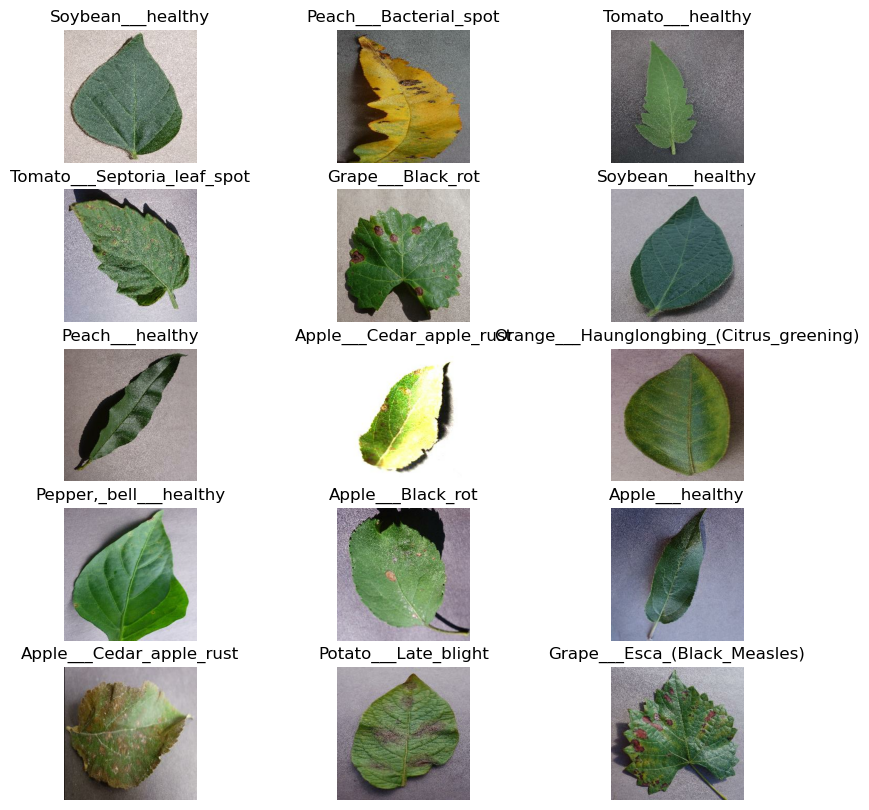

In [5]:
plt.figure(figsize = (10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(15):
        ax = plt.subplot(5,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint0"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
#split dataset into training(80%), validation(10%) and test(10%) datasets

def get_dataset_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=100):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=13)
        
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

In [9]:
print(len(train_ds))
print(len(test_ds))
print(len(val_ds))

2196
276
274


In [10]:
#this part is optimization so training is faster
#as first batch is getting trained, second batch is loaded to CPU as it awaits training

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
#Preprocessing - Resizing - resize images given to model to one size(for this model 256x256)
#                Rescaling - divide numpy array by 255

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [12]:
#data augmentation - apllies different transformations to each image(flipping,contrasts,zoom,etc)
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [13]:
#model training
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 38

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [15]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [18]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds,
)

Epoch 1/13
2196/2196 [==============================] - 5579s 2s/step - loss: 1.8399 - accuracy: 0.4551 - val_loss: 0.8219 - val_accuracy: 0.7420
Epoch 2/13
2196/2196 [==============================] - 5328s 2s/step - loss: 0.6065 - accuracy: 0.8049 - val_loss: 0.5799 - val_accuracy: 0.8163
Epoch 3/13
2196/2196 [==============================] - 5507s 2s/step - loss: 0.4254 - accuracy: 0.8606 - val_loss: 0.3547 - val_accuracy: 0.8831
Epoch 4/13
2196/2196 [==============================] - 5235s 2s/step - loss: 0.3377 - accuracy: 0.8884 - val_loss: 0.4104 - val_accuracy: 0.8643
Epoch 5/13
2196/2196 [==============================] - 5220s 2s/step - loss: 0.2919 - accuracy: 0.9029 - val_loss: 0.4503 - val_accuracy: 0.8614
Epoch 6/13
2196/2196 [==============================] - 5064s 2s/step - loss: 0.2606 - accuracy: 0.9136 - val_loss: 0.3223 - val_accuracy: 0.8879
Epoch 7/13
2196/2196 [==============================] - 5188s 2s/step - loss: 0.2329 - accuracy: 0.9227 - val_loss: 0.3065 -

In [19]:
scores = model.evaluate(test_ds)

276/276 [==============================] - 1527s 463ms/step - loss: 0.2316 - accuracy: 0.9286


In [20]:
history.params

{'verbose': 1, 'epochs': 13, 'steps': 2196}

In [21]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

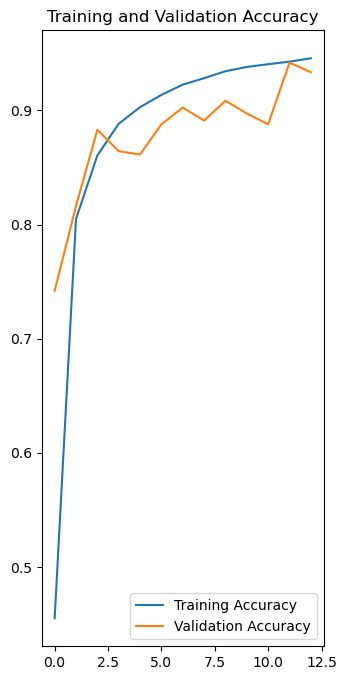

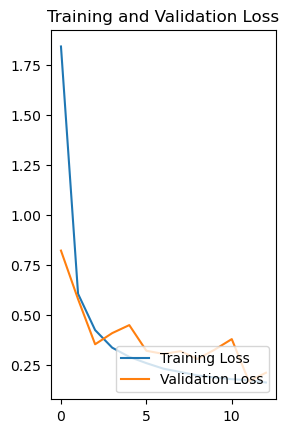

In [23]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.show()

Image Prediction
actual label:  Strawberry___healthy
1/1 [==============================] - 38s 38s/step
predicted label:  Strawberry___healthy


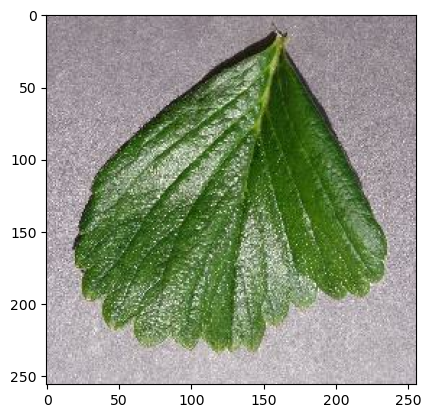

In [35]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('Image Prediction')
    plt.imshow(first_image)
    print('actual label: ', class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print('predicted label: ', class_names[np.argmax(batch_prediction[0])])

In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) 
    
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

1/1 [==============================] - 0s 42ms/step


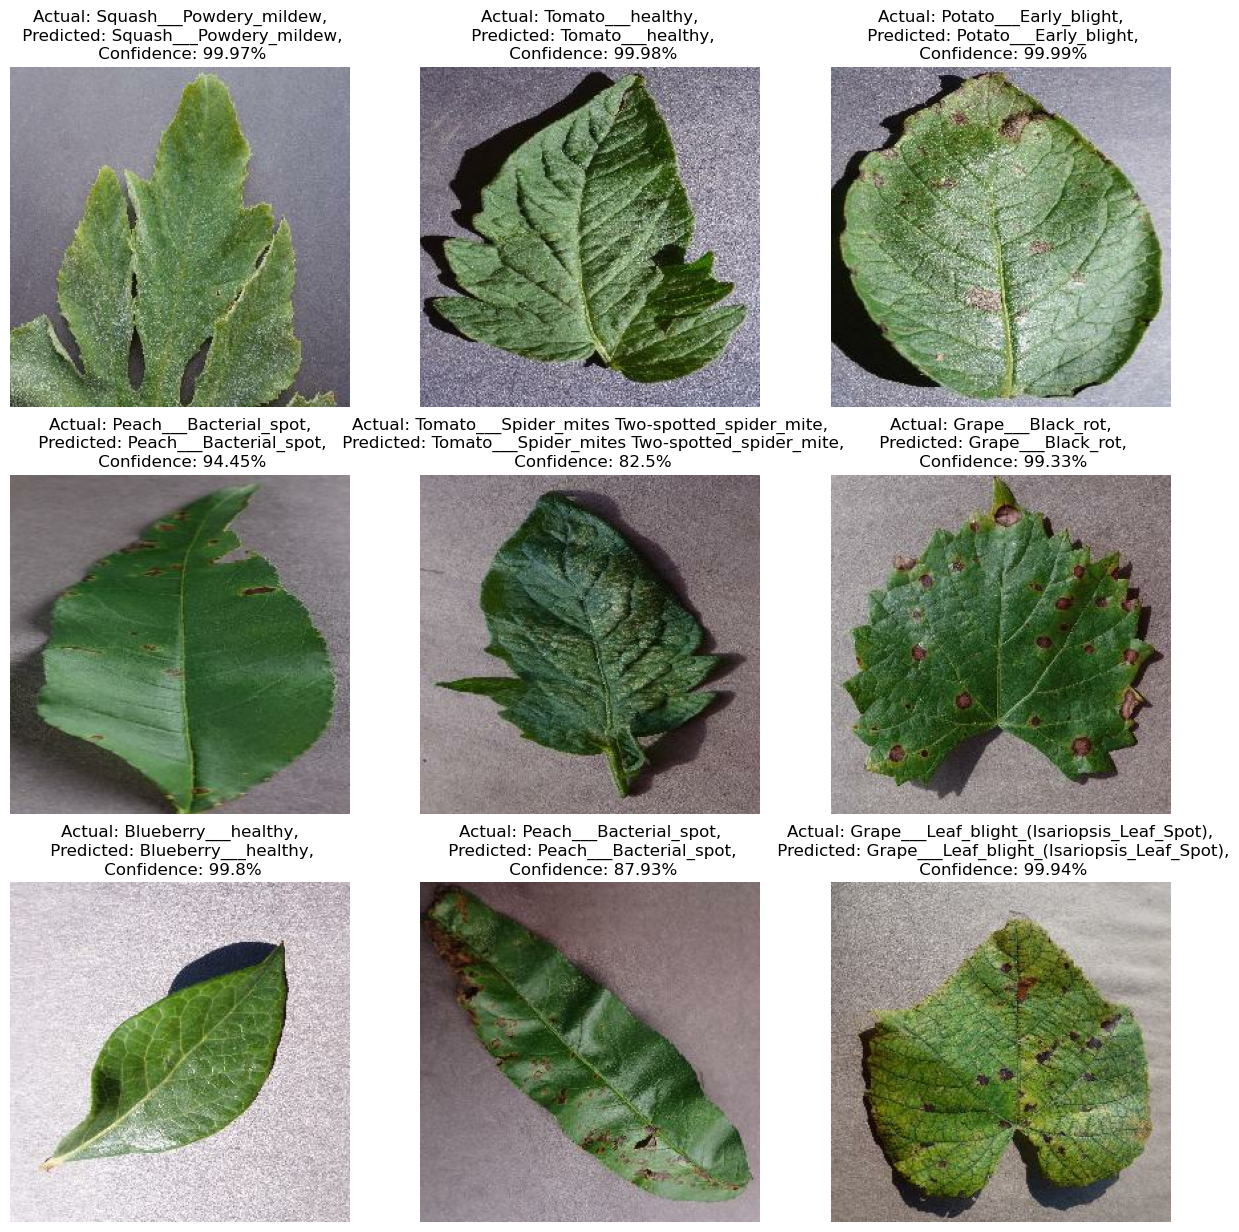

In [26]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}%")
        plt.axis('off')

In [51]:
# model_version = max([int(i) for i in os.listdir('C:/Users/EDWIN/projects/vsProjects/Python/ML/plant_diseases/models/') + [0]]) + 1
# model.save(f"C:/Users/EDWIN/projects/vsProjects/Python/ML/plant_diseases/models/{model_version}")

model_version = max([int(i.split()[-1]) for i in os.listdir('C:/Users/EDWIN/projects/vsProjects/Python/ML/plant_diseases/models/') if i.startswith('model_version')] + [0]) + 1
model.save(f"C:/Users/EDWIN/projects/vsProjects/Python/ML/plant_diseases/models/model_version {model_version}")

INFO:tensorflow:Assets written to: C:/Users/EDWIN/projects/vsProjects/Python/ML/plant_diseases/models/model_version 1\assets


INFO:tensorflow:Assets written to: C:/Users/EDWIN/projects/vsProjects/Python/ML/plant_diseases/models/model_version 1\assets


1/1 [==============================] - 0s 107ms/step


(-0.5, 255.5, 255.5, -0.5)

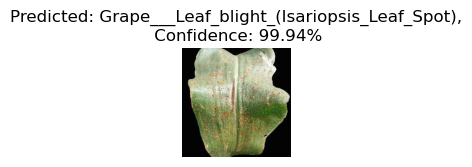

In [54]:
from PIL import Image
import numpy as np

image_path = 'C:/Users/EDWIN/projects/vsProjects/Python/ML/plant_diseases/cornrust.jpg'

# Load the image
img = Image.open(image_path)

# Convert the image to a numpy array
img_array = np.array(img)

# Display the image
ax = plt.subplot(3, 3, 1)
plt.imshow(img_array)

# Predict the class of the image
predicted_class, confidence = predict(model, image_path)
# actual_class = class_names

plt.title(f"Predicted: {predicted_class},\n Confidence: {confidence}%")
plt.axis('off')

In [52]:
print(help(tf.lite.TFLiteConverter))

Help on class TFLiteConverterV2 in module tensorflow.lite.python.lite:

class TFLiteConverterV2(TFLiteFrozenGraphConverterV2)
 |  TFLiteConverterV2(funcs, trackable_obj=None)
 |  
 |  Converts a TensorFlow model into TensorFlow Lite model.
 |  
 |  Attributes:
 |    optimizations: Experimental flag, subject to change. Set of optimizations to
 |      apply. e.g {tf.lite.Optimize.DEFAULT}. (default None, must be None or a
 |      set of values of type `tf.lite.Optimize`)
 |    representative_dataset: A generator function used for integer quantization
 |      where each generated sample has the same order, type and shape as the
 |      inputs to the model. Usually, this is a small subset of a few hundred
 |      samples randomly chosen, in no particular order, from the training or
 |      evaluation dataset. This is an optional attribute, but required for full
 |      integer quantization, i.e, if `tf.int8` is the only supported type in
 |      `target_spec.supported_types`. Refer to `tf.

In [57]:
# Convert the model
saved_model_dir = 'C:/Users/EDWIN/projects/vsProjects/Python/ML/plant_diseases/models/model_version 1'

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) 
# tflite_model = converter.convert()

converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_quant_model)